<a href="https://colab.research.google.com/github/BennettHilck12/DraftEdge/blob/main/DraftEdge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 5450 Final Project: DraftEdge

##### Bennett Hilck, Ethan Xia, Mohammed Soufan


# Part 1: Introduction



For our final project, we sought to better understand how NBA teams can draft players more effectively by predicting which NCAA D1 prospects are most likely to outperform expectations at the professional level. To pursue this goal, we compiled and analyzed several datasets containing college performance statistics, NBA Combine measurements and performance statistics, and eventual NBA outcomes.


By aggregrating and merging these data sources, we aim to identify advanced or undervalued metrics that may be overlook in traditional scouting evaluations. This approach alows us to quantitatvely asses why certain highly drafted players become "busts," while others selected later dramatically exceed their draft position.


Given the high variance and high cost associated with drafting, our project highlights non-obvious predictors that could help inform more data-driven decision-making and potentially reshape how teams and scouts approach future NBA drafts.


We hope that you find our project impactful!

# Part 2: Data Loading & Preprocessing


First, we must import all relevant libraries for our project. We will use all supplemental libraries throughout our project.

In [ ]:
# Imports + Installs
!pip install category_encoders
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
import folium
import numpy as np
import category_encoders as ce
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
import copy
from xgboost import XGBRegressor
from folium.plugins import HeatMap
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn import datasets, linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from torch.utils import data as data_utils
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.4 MB/s eta 0:00:00


## 2.1 Data Mounting + Storage

Because our datasets are quite large, often containing thousands of player seasons, detailed college statistics, and multiple years of NBA Combine measurements—we decided to upload them to Google Drive rather than store them locally. This allows us to efficiently access and manage the data from within our notebook environment without running into storage limitations or upload constraints. Hosting the data on Google Drive also ensures easier collaboration, as all team members can work from the same centralized, version-consistent files.

In [ ]:
# Data Loading via Google Docs
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.2 Loading and Preprocessing NBA Combine Data

We wanted to add a disclaimer that most of our data was scraped from multiple websites, such as barttorvik.com and basketball-reference.com. We scraped an HTML table and used a Chromium headless browser to continually load more of the table.

First, let's load in our data from the NBA combine.

In [ ]:
file_path = '/content/drive/MyDrive/final_project_datasets/draft_combine_stats.csv'
combine_df = pd.read_csv(file_path)
display(combine_df.head(10))

,season,player_id,first_name,last_name,player_name,position,height_wo_shoes,height_wo_shoes_ft_in,height_w_shoes,height_w_shoes_ft_in,...,spot_nba_break_right,spot_nba_corner_right,off_drib_fifteen_break_left,off_drib_fifteen_top_key,off_drib_fifteen_break_right,off_drib_college_break_left,off_drib_college_top_key,off_drib_college_break_right,on_move_fifteen,on_move_college
0,2001,12033,Adam,Allenspach,Adam Allenspach,C,83.50,6' 11.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,2240,Gilbert,Arenas,Gilbert Arenas,SG,74.25,6' 2.25'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001,2220,Brandon,Armstrong,Brandon Armstrong,SG,75.50,6' 3.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001,2203,Shane,Battier,Shane Battier,SF-PF,80.25,6' 8.25'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001,12034,Cookie,Belcher,Cookie Belcher,SG-PG,75.00,6' 3'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2001,2294,Charlie,Bell,Charlie Bell,PG,74.50,6' 2.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2001,2257,Ruben,Boumtje-Boumtje,Ruben Boumtje-Boumtje,C,83.50,6' 11.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2001,12035,Calvin,Bowman,Calvin Bowman,PF,80.75,6' 8.75'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2001,2214,Michael,Bradley,Michael Bradley,PF,81.50,6' 9.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2001,2249,Jamison,Brewer,Jamison Brewer,PG,74.50,6' 2.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
combine_df.dtypes

,0
season,int64
player_id,int64
first_name,object
last_name,object
player_name,object
position,object
height_wo_shoes,float64
height_wo_shoes_ft_in,object
height_w_shoes,float64
height_w_shoes_ft_in,object


In [ ]:
combine_df.describe()

,season,player_id,height_wo_shoes,height_w_shoes,weight,wingspan,standing_reach,body_fat_pct,hand_length,hand_width,standing_vertical_leap,max_vertical_leap,lane_agility_time,modified_lane_agility_time,three_quarter_sprint,bench_press
count,1202.000000,1.202000e+03,1153.000000,1008.000000,1152.000000,1153.000000,1152.000000,1003.000000,719.000000,719.000000,1017.000000,1017.000000,1008.000000,411.000000,1012.000000,808.000000
mean,2012.536606,2.350133e+06,77.570902,78.796577,214.902604,82.478187,103.593663,7.352313,8.720793,9.448887,29.240167,34.637168,11.384444,3.079221,3.282213,10.155941
std,6.561620,5.660210e+07,3.334605,3.322625,25.718878,3.986623,4.880218,2.748712,0.481028,0.717066,3.054645,3.648106,0.584896,0.229143,0.131850,5.389231
min,2001.000000,-1.000000e+00,67.750000,69.000000,154.400000,70.000000,89.500000,2.600000,7.500000,7.000000,20.500000,25.000000,9.650000,2.220000,2.910000,0.000000
25%,2007.000000,1.011455e+05,75.250000,76.500000,195.950000,80.000000,100.000000,5.400000,8.500000,9.000000,27.000000,32.000000,10.970000,2.970000,3.190000,6.000000
50%,2012.000000,2.031470e+05,77.750000,79.000000,212.900000,82.750000,104.000000,6.700000,8.750000,9.500000,29.000000,34.500000,11.320000,3.100000,3.270000,10.000000
75%,2018.000000,1.629014e+06,80.000000,81.250000,233.000000,85.250000,107.000000,8.600000,9.000000,10.000000,31.500000,37.000000,11.720000,3.230000,3.360000,14.000000
max,2023.000000,1.962937e+09,89.250000,91.000000,314.000000,98.250000,122.500000,21.000000,10.500000,12.000000,39.500000,45.500000,13.440000,3.760000,3.810000,26.000000


However, we know that the NBA combine is invite only, and many players who get drafted do not go to the combine. For that, we can look towards the entirety of NCAA D1 Men's Basketball data.

## 2.3 Loading and Preprocessing NCAA Data

And let's also take a look at our NCAA D1 player stats, which we scraped from barttorvik.com, a live NCAA D1 player stats tracker by season.

In [ ]:
file_path = '/content/drive/MyDrive/final_project_datasets/battorvikPlayerData.xlsx'
ncaa_df = pd.read_excel(file_path)
display(ncaa_df.head(10))

,Rk,Player,Class,Team,Conf,Min%,PRPG!,BPM,ORtg,Usg,...,DR,Ast,TO,Blk,Stl,FTR,2P,3P/100,3P,Year
0,1,Bennett Stirtz,Jr,Drake,MVC,98.8,6.4,10.0,126.4,26.1,...,14.0,34.0,13.1,1.0,3.3,38.6,0.545,7.7,0.396,2025
1,2,Bruce Thornton,Jr,Ohio St.,B10,88.4,6.3,8.7,130.0,22.0,...,10.0,25.1,10.8,0.4,1.8,41.8,0.547,7.0,0.424,2025
2,3,Ryan Kalkbrenner,Sr,Creighton,BE,83.1,6.1,11.1,129.2,22.3,...,18.4,10.0,11.2,7.3,0.9,38.6,0.706,3.0,0.344,2025
3,4,Eric Dixon,Sr,Villanova,BE,84.3,6.1,7.3,116.7,32.9,...,12.6,13.1,11.8,1.1,1.5,35.8,0.483,13.1,0.407,2025
4,5,Cooper Flagg,Fr,Duke,ACC,72.8,6.0,14.9,123.0,30.8,...,21.2,26.8,13.5,4.9,2.8,42.9,0.517,7.2,0.385,2025
5,6,Trey Kaufman-Renn,Jr,Purdue,B10,76.9,5.7,7.9,118.1,31.1,...,15.4,16.8,13.9,1.2,1.4,42.8,0.597,0.4,0.429,2025
6,7,Johni Broome,Sr,Auburn,SEC,71.4,5.7,12.9,118.5,30.6,...,26.0,19.5,9.9,7.5,1.8,39.0,0.559,4.8,0.278,2025
7,8,Braden Smith,Jr,Purdue,B10,92.6,5.7,9.4,116.1,26.6,...,13.5,44.1,18.6,0.7,3.5,20.3,0.469,9.9,0.381,2025
8,9,Kam Jones,Sr,Marquette,BE,83.9,5.7,9.3,118.1,29.2,...,13.6,38.1,11.1,0.9,2.4,16.0,0.586,10.6,0.311,2025
9,10,Tyson Degenhart,Sr,Boise St.,MWC,84.5,5.6,7.6,126.8,23.8,...,15.3,10.3,10.7,0.9,1.1,50.5,0.618,7.6,0.349,2025


In [ ]:
ncaa_df.dtypes

,0
rk,int64
player,object
class,object
team,object
conf,object
min%,float64
prpg!,float64
bpm,float64
ortg,float64
usg_pct,float64


In [ ]:
ncaa_df.describe()

,rk,min%,prpg!,bpm,ortg,usg_pct,efg,ts_pct,or,dr,ast,tov,blk,stl,ftr,two_p,3p/100,three_p,year
count,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000
mean,1081.626684,63.976410,1.592120,0.512914,102.649598,20.169825,50.128917,53.483460,5.098132,13.164641,13.685518,18.678477,1.795090,1.885247,36.047461,0.482052,5.916292,0.293371,2015.572552
std,624.707228,13.710255,1.350229,3.646744,10.544458,4.603789,6.258371,5.652769,3.600281,4.857638,7.637416,5.055083,2.158322,0.801265,15.801580,0.077373,4.134366,0.140039,4.604466
min,1.000000,40.000000,-2.700000,-13.300000,55.400000,6.100000,18.300000,20.300000,0.000000,2.100000,0.000000,2.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2008.000000
25%,541.000000,52.500000,0.600000,-2.000000,95.800000,16.900000,46.000000,49.800000,2.100000,9.400000,7.900000,15.200000,0.400000,1.300000,24.700000,0.431000,2.400000,0.259000,2012.000000
50%,1081.000000,64.000000,1.500000,0.400000,102.900000,19.900000,50.000000,53.500000,4.100000,12.400000,12.000000,18.200000,1.000000,1.800000,33.900000,0.481000,5.900000,0.330000,2016.000000
75%,1621.750000,75.100000,2.400000,2.900000,109.700000,23.200000,54.100000,57.200000,7.600000,16.300000,18.000000,21.600000,2.300000,2.300000,45.300000,0.532000,9.000000,0.375000,2020.000000
max,2255.000000,98.000000,7.600000,18.700000,161.400000,38.500000,88.300000,80.400000,23.700000,39.200000,52.600000,54.100000,18.800000,7.600000,147.900000,1.000000,23.100000,1.000000,2023.000000


## 2.4 Loading and Preprocessing NBA Draft Data

Let's also take a look at our NBA Draft data, which we scraped from basketball-reference.com, a live NBA tracker

In [ ]:
file_path = '/content/drive/MyDrive/final_project_datasets/nba_draft_2000_2025_clean.csv'
draft_df = pd.read_csv(file_path)
display(draft_df.head(10))

,Rk,Pk,Tm,Player,College,Yrs,G,MP,PTS,TRB,...,FT%,MP.1,PTS.1,TRB.1,AST.1,WS,WS/48,BPM,VORP,Year
0,1.0,1.0,NJN,Kenyon Martin,Cincinnati,15.0,757,23134,9325,5159,...,.629,30.6,12.3,6.8,1.9,48.0,.100,0.1,12.1,2000
1,2.0,2.0,VAN,Stromile Swift,LSU,9.0,547,10804,4582,2535,...,.699,19.8,8.4,4.6,0.5,21.3,.095,-1.6,1.1,2000
2,3.0,3.0,LAC,Darius Miles,NaN,7.0,446,11730,4507,2190,...,.590,26.3,10.1,4.9,1.9,9.5,.039,-1.0,3.0,2000
3,4.0,4.0,CHI,Marcus Fizer,Iowa State,6.0,289,6032,2782,1340,...,.691,20.9,9.6,4.6,1.2,2.7,.022,-3.7,-2.6,2000
4,5.0,5.0,ORL,Mike Miller,Florida,17.0,1032,27812,10973,4376,...,.769,26.9,10.6,4.2,2.6,60.7,.105,0.8,19.8,2000
5,6.0,6.0,ATL,DerMarr Johnson,Cincinnati,7.0,344,5930,2121,769,...,.789,17.2,6.2,2.2,0.9,6.4,.052,-1.6,0.6,2000
6,7.0,7.0,CHI,Chris Mihm,Texas,8.0,436,8758,3262,2302,...,.704,20.1,7.5,5.3,0.5,13.3,.073,-3.9,-4.3,2000
7,8.0,8.0,CLE,Jamal Crawford,Michigan,20.0,1327,38994,19419,2948,...,.862,29.4,14.6,2.2,3.4,60.7,.075,-0.1,18.4,2000
8,9.0,9.0,HOU,Joel Przybilla,Minnesota,13.0,592,11733,2293,3665,...,.557,19.8,3.9,6.2,0.4,23.0,.094,-1.7,0.8,2000
9,10.0,10.0,ORL,Keyon Dooling,Missouri,13.0,728,14134,5067,964,...,.799,19.4,7.0,1.3,2.2,18.5,.063,-2.0,-0.2,2000


In [ ]:
draft_df.dtypes

,0
Rk,float64
Pk,float64
Tm,object
Player,object
College,object
Yrs,object
G,object
MP,object
PTS,object
TRB,object


In [ ]:
draft_df.describe()

,Rk,Pk,Year
count,1545.000000,1545.000000,1578.000000
mean,30.277023,30.257605,2012.555767
std,17.217246,17.200612,7.479822
min,1.000000,1.000000,2000.000000
25%,15.000000,15.000000,2006.000000
50%,30.000000,30.000000,2013.000000
75%,45.000000,45.000000,2019.000000
max,60.000000,60.000000,2025.000000


Here, we can see that only 3 columns in draft_df are of dtype int. This means that we will have to convert the rest of the columns from dtype object to int

## 2.5 Loading and Preprocessing NBA Player Data

We will also load in our NBA player data, which we scraped from ESPN and also basketball-reference.com. We will merge these two dataframes together later in part 3.

In [ ]:
file_path = '/content/drive/MyDrive/final_project_datasets/nba_player_stats_2000_2023_fixed_years_multiTM_clean.csv'
nba_br_df = pd.read_csv(file_path)
display(nba_br_df.head(10))

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Year
0,1.0,Shaquille O'Neal,27.0,LAL,C,79.0,79.0,40.0,12.1,21.1,...,9.4,13.6,3.8,0.5,3.0,2.8,3.2,29.7,"MVP-1,DPOY-2,AS,NBA1,DEF2",2000
1,2.0,Allen Iverson,24.0,PHI,SG,70.0,70.0,40.8,10.4,24.8,...,2.8,3.8,4.7,2.1,0.1,3.3,2.3,28.4,"MVP-7,AS,NBA2",2000
2,3.0,Grant Hill,27.0,DET,SF,74.0,74.0,37.5,9.4,19.2,...,5.3,6.6,5.2,1.4,0.6,3.2,2.6,25.8,"MVP-8,AS,NBA2",2000
3,4.0,Vince Carter,23.0,TOR,SF,82.0,82.0,38.1,9.6,20.7,...,4.0,5.8,3.9,1.3,1.1,2.2,3.2,25.7,"MVP-10,AS,NBA3",2000
4,5.0,Karl Malone,36.0,UTA,PF,82.0,82.0,35.9,9.2,18.0,...,7.4,9.5,3.7,1.0,0.9,2.8,2.8,25.5,"MVP-4,AS,NBA2",2000
5,6.0,Chris Webber,26.0,SAC,PF,75.0,75.0,38.4,10.0,20.6,...,8.0,10.5,4.6,1.6,1.7,2.9,3.5,24.5,"MVP-9,AS,NBA3",2000
6,7.0,Gary Payton,31.0,SEA,PG,82.0,82.0,41.8,9.1,20.3,...,5.2,6.5,8.9,1.9,0.2,2.7,2.2,24.2,"MVP-6,DPOY-5,AS,NBA1,DEF1",2000
7,8.0,Jerry Stackhouse,25.0,DET,SG,82.0,82.0,38.4,7.5,17.6,...,2.4,3.8,4.5,1.3,0.4,3.8,2.3,23.6,AS,2000
8,9.0,Tim Duncan,23.0,SAS,PF,74.0,74.0,38.9,8.5,17.3,...,8.9,12.4,3.2,0.9,2.2,3.3,2.8,23.2,"MVP-5,AS,NBA1,DEF1",2000
9,10.0,Kevin Garnett,23.0,MIN,PF,81.0,81.0,40.0,9.4,18.8,...,9.0,11.8,5.0,1.5,1.6,3.3,2.5,22.9,"MVP-2,DPOY-7,AS,NBA1,DEF1",2000


In [ ]:
nba_br_df.dtypes

,0
Rk,float64
Player,object
Age,float64
Team,object
Pos,object
G,float64
GS,float64
MP,float64
FG,float64
FGA,float64


In [ ]:
nba_br_df.describe()

,Rk,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
count,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9651.000000,9652.000000,9652.000000,...,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9652.000000,9654.000000
mean,202.223270,26.630957,57.300456,29.485081,22.592199,3.531082,7.809283,0.449005,0.731527,2.062257,...,1.029217,2.948974,3.976357,2.082252,0.710205,0.454165,1.302176,1.983972,9.474834,2011.326808
std,117.209815,4.287360,21.938514,29.082333,8.849359,2.114101,4.473394,0.072291,0.760087,1.996047,...,0.823210,1.772473,2.444510,1.846758,0.421422,0.480060,0.777352,0.719978,5.851219,6.952667
min,1.000000,18.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000
25%,101.000000,23.000000,44.000000,2.000000,15.600000,1.900000,4.400000,0.409000,0.000000,0.200000,...,0.400000,1.700000,2.200000,0.800000,0.400000,0.100000,0.700000,1.500000,5.000000,2005.000000
50%,202.000000,26.000000,64.000000,18.000000,22.300000,3.000000,6.700000,0.443000,0.500000,1.700000,...,0.800000,2.600000,3.400000,1.500000,0.600000,0.300000,1.100000,2.000000,8.000000,2011.000000
75%,302.000000,30.000000,75.000000,58.000000,29.900000,4.700000,10.400000,0.484000,1.200000,3.300000,...,1.400000,3.800000,5.100000,2.800000,0.900000,0.600000,1.700000,2.500000,12.600000,2017.000000
max,444.000000,44.000000,85.000000,83.000000,43.700000,12.200000,27.800000,1.000000,5.300000,13.200000,...,5.500000,11.500000,16.300000,11.700000,2.900000,3.700000,5.700000,6.000000,36.100000,2023.000000


In [ ]:
file_path = '/content/drive/MyDrive/final_project_datasets/nbaPlayerData.xlsx'
nba_espn_df = pd.read_excel(file_path)
display(nba_espn_df.head(10))

,RK,Player,Team,3P%,3PA,3PM,AST,BLK,DD2,FG%,...,FTM,GP,MIN,POS,PTS,REB,STL,TD3,TO,Year
0,-,Allen Iverson,PHI,29.1,4.5,1.3,5.5,0.2,4,39.8,...,7.9,60,43.7,SG,31.4,4.5,2.8,1,4.0,2002
1,-,Shaquille O'Neal,LAL,0.0,0.0,0.0,3.0,2.0,40,57.9,...,5.9,67,36.1,C,27.2,10.7,0.6,0,2.6,2002
2,-,Paul Pierce,BOS,40.4,6.3,2.6,3.2,1.0,17,44.2,...,6.3,82,40.3,SF,26.1,6.9,1.9,0,2.9,2002
3,-,Tracy McGrady,ORL,36.4,3.7,1.4,5.3,1.0,24,45.1,...,5.5,76,38.3,SG,25.6,7.9,1.6,1,2.5,2002
4,-,Tim Duncan,SA,10.0,0.1,0.0,3.7,2.5,67,50.8,...,6.8,82,40.6,C,25.5,12.7,0.7,0,3.2,2002
5,-,Kobe Bryant,LAL,25.0,1.7,0.4,5.5,0.4,11,46.9,...,6.1,80,38.3,SF,25.2,5.5,1.5,1,2.8,2002
6,-,Vince Carter,TOR,38.7,5.2,2.0,4.0,0.7,5,42.8,...,4.1,60,39.8,G,24.7,5.2,1.6,0,2.6,2002
7,-,Chris Webber,SAC,26.3,0.4,0.1,4.8,1.4,31,49.5,...,4.7,54,38.4,C,24.5,10.1,1.7,0,2.9,2002
8,-,Dirk Nowitzki,DAL,39.7,4.6,1.8,2.4,1.0,38,47.7,...,5.8,76,38.0,F,23.4,9.9,1.1,0,1.9,2002
9,-,Michael Jordan,WSH,18.9,0.9,0.2,5.2,0.4,8,41.6,...,4.4,60,34.9,G,22.9,5.7,1.4,0,2.7,2002


In [ ]:
nba_espn_df.dtypes

,0
RK,object
Player,object
Team,object
3P%,float64
3PA,float64
3PM,float64
AST,float64
BLK,float64
DD2,int64
FG%,float64


In [ ]:
nba_espn_df.describe()

,3P%,3PA,3PM,AST,BLK,DD2,FG%,FGA,FGM,FT%,FTA,FTM,GP,MIN,PTS,REB,STL,TD3,TO,Year
count,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000,11095.000000
mean,26.352591,2.040297,0.718558,1.907959,0.417071,4.434971,44.596413,7.078260,3.204380,71.484308,1.968247,1.489797,52.390626,20.571104,8.614430,3.648481,0.646868,0.151510,1.166886,2014.087787
std,16.682662,2.023629,0.772698,1.819998,0.453910,9.385283,8.959944,4.673945,2.216838,18.393246,1.758923,1.412914,24.372468,9.720884,6.121573,2.456222,0.427746,1.233593,0.798064,7.110542
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000,2002.000000
25%,15.400000,0.200000,0.000000,0.600000,0.100000,0.000000,40.300000,3.400000,1.500000,66.200000,0.800000,0.500000,34.000000,12.600000,3.900000,1.900000,0.300000,0.000000,0.600000,2008.000000
50%,32.100000,1.500000,0.500000,1.300000,0.300000,0.000000,44.200000,6.000000,2.700000,75.400000,1.400000,1.000000,59.000000,20.200000,7.100000,3.100000,0.600000,0.000000,1.000000,2014.000000
75%,37.200000,3.300000,1.200000,2.500000,0.500000,4.000000,48.700000,9.800000,4.500000,82.200000,2.600000,2.000000,73.000000,28.650000,11.900000,4.800000,0.900000,0.000000,1.600000,2020.000000
max,100.000000,13.200000,5.300000,11.700000,3.800000,77.000000,100.000000,27.800000,12.200000,100.000000,12.300000,10.200000,85.000000,43.700000,36.100000,16.000000,3.000000,42.000000,5.700000,2025.000000


We want to normalize the team format across dataframes. In nba_espn_df, players who played on multiple teams (IND/CHI, for example) are represented with a '/'. We will keep this format.

In [ ]:
def replace_teams(team_str):
    if not isinstance(team_str, str):  # handle NaN or other non-string values
        return team_str
    teams = team_str.split('/')
    if len(teams) == 1:
        return team_str  # single team stays as is
    else:
        return f"{len(teams)}TM"

nba_espn_df['Team'] = nba_espn_df['Team'].apply(replace_teams)


In [ ]:
nba_espn_df.head(40)

,RK,Player,Team,3P%,3PA,3PM,AST,BLK,DD2,FG%,...,FTM,GP,MIN,POS,PTS,REB,STL,TD3,TO,Year
0,-,Allen Iverson,PHI,29.1,4.5,1.3,5.5,0.2,4,39.8,...,7.9,60,43.7,SG,31.4,4.5,2.8,1,4.0,2002
1,-,Shaquille O'Neal,LAL,0.0,0.0,0.0,3.0,2.0,40,57.9,...,5.9,67,36.1,C,27.2,10.7,0.6,0,2.6,2002
2,-,Paul Pierce,BOS,40.4,6.3,2.6,3.2,1.0,17,44.2,...,6.3,82,40.3,SF,26.1,6.9,1.9,0,2.9,2002
3,-,Tracy McGrady,ORL,36.4,3.7,1.4,5.3,1.0,24,45.1,...,5.5,76,38.3,SG,25.6,7.9,1.6,1,2.5,2002
4,-,Tim Duncan,SA,10.0,0.1,0.0,3.7,2.5,67,50.8,...,6.8,82,40.6,C,25.5,12.7,0.7,0,3.2,2002
5,-,Kobe Bryant,LAL,25.0,1.7,0.4,5.5,0.4,11,46.9,...,6.1,80,38.3,SF,25.2,5.5,1.5,1,2.8,2002
6,-,Vince Carter,TOR,38.7,5.2,2.0,4.0,0.7,5,42.8,...,4.1,60,39.8,G,24.7,5.2,1.6,0,2.6,2002
7,-,Chris Webber,SAC,26.3,0.4,0.1,4.8,1.4,31,49.5,...,4.7,54,38.4,C,24.5,10.1,1.7,0,2.9,2002
8,-,Dirk Nowitzki,DAL,39.7,4.6,1.8,2.4,1.0,38,47.7,...,5.8,76,38.0,F,23.4,9.9,1.1,0,1.9,2002
9,-,Michael Jordan,WSH,18.9,0.9,0.2,5.2,0.4,8,41.6,...,4.4,60,34.9,G,22.9,5.7,1.4,0,2.7,2002


## 2.6 Loading and Preprocessing Advanced Statistics

Finally, we will load in our data of advanced statistics, which we also scraped from basketball-reference.com. We hope that these advanced statistics can include specific statistics that will make underdog or outperforming players stand out.

In [ ]:
file_path = '/content/drive/MyDrive/final_project_datasets/NBA_Advanced_stats_2008-2025_fixed_years_multiTM_clean.csv'
advanced_df = pd.read_csv(file_path)
display(advanced_df.head(10))

,Rk,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards,Year
0,1,Allen Iverson,32,DEN,SG,82,82,3424,20.9,0.567,...,8.9,2.8,11.6,0.163,3.4,-0.7,2.7,4.0,AS,2008
1,2,Joe Johnson,26,ATL,SG,82,82,3343,17.3,0.535,...,5.3,1.7,7.0,0.100,2.7,-1.5,1.2,2.7,AS,2008
2,3,Andre Iguodala,24,PHI,SF,82,82,3242,19.0,0.543,...,5.3,4.4,9.6,0.143,2.5,1.5,4.0,4.9,NaN,2008
3,4,Richard Jefferson,27,NJN,SF,82,82,3200,17.4,0.571,...,6.1,1.5,7.6,0.114,1.6,-1.3,0.3,1.8,NaN,2008
4,5,Baron Davis,28,GSW,PG,82,82,3196,19.8,0.523,...,5.9,2.8,8.7,0.131,3.2,0.3,3.6,4.5,NaN,2008
5,6,Kobe Bryant,29,LAL,SG,82,82,3192,24.2,0.576,...,9.5,4.3,13.8,0.208,5.2,0.6,5.8,6.3,"MVP-1,DPOY-5,AS,NBA1,DEF1",2008
6,7,Jamal Crawford,27,NYK,SG,80,80,3190,16.0,0.528,...,4.6,0.4,5.0,0.076,2.1,-1.8,0.3,1.9,NaN,2008
7,8,Jason Richardson,27,CHA,SF,82,82,3149,18.4,0.554,...,4.8,2.6,7.4,0.113,3.3,-0.3,3.0,4.0,NaN,2008
8,9,Dwight Howard,22,ORL,C,82,82,3088,22.9,0.619,...,6.4,6.4,12.9,0.200,1.6,1.2,2.8,3.7,"MVP-5,DPOY-7,AS,NBA1,DEF2",2008
9,10,Rashard Lewis,28,ORL,PF,81,81,3076,16.7,0.591,...,6.1,3.7,9.8,0.153,2.7,0.4,3.1,4.0,NaN,2008


In [ ]:
advanced_df.dtypes

,0
Rk,int64
Player,object
Age,int64
Team,object
Pos,object
G,int64
GS,int64
MP,int64
PER,float64
TS%,float64


In [ ]:
advanced_df.describe()

,Rk,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
count,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,...,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000
mean,197.477112,26.443487,59.900254,30.300650,1438.230432,14.001724,0.544854,0.308214,0.267212,5.167717,...,18.924753,1.621574,1.463281,3.085081,0.091586,-0.650834,-0.021334,-0.672422,0.759226,2016.463549
std,114.162288,4.235389,17.154287,28.154161,732.954808,4.471937,0.056684,0.217415,0.137119,3.855049,...,5.176462,2.029380,1.074122,2.808047,0.058014,2.460416,1.163553,2.806183,1.373162,5.154941
min,1.000000,19.000000,5.000000,0.000000,109.000000,-4.800000,0.231000,0.000000,0.000000,0.000000,...,3.700000,-3.300000,-0.500000,-2.100000,-0.193000,-11.000000,-4.200000,-11.900000,-2.000000,2008.000000
25%,99.000000,23.000000,49.000000,4.000000,813.250000,10.900000,0.510000,0.101000,0.172000,2.100000,...,15.200000,0.200000,0.600000,1.000000,0.054000,-2.300000,-0.800000,-2.500000,-0.100000,2012.000000
50%,197.000000,26.000000,63.000000,20.000000,1411.500000,13.500000,0.545000,0.323000,0.243000,3.700000,...,18.300000,1.100000,1.200000,2.400000,0.091000,-0.800000,-0.100000,-0.800000,0.300000,2016.000000
75%,295.000000,29.000000,74.000000,58.000000,2025.000000,16.600000,0.581000,0.467000,0.333000,7.675000,...,22.100000,2.500000,2.000000,4.400000,0.126000,0.800000,0.700000,0.900000,1.200000,2021.000000
max,435.000000,43.000000,84.000000,83.000000,3424.000000,34.100000,0.804000,0.937000,1.286000,23.100000,...,41.700000,14.800000,7.700000,20.300000,0.325000,10.300000,5.500000,13.700000,11.800000,2025.000000


## 2.7 Loading and Preprocessing NBA Draft Data

Finally, we need to load the NBA Draft data, which will assist in our EDA and modeling later.

In [ ]:
file_path = '/content/drive/MyDrive/final_project_datasets/nba_draft_2000_2025_clean.csv'
draft_df = pd.read_csv(file_path)
display(draft_df.head(10))

,Rk,Pk,Tm,Player,College,Yrs,G,MP,PTS,TRB,...,FT%,MP.1,PTS.1,TRB.1,AST.1,WS,WS/48,BPM,VORP,Year
0,1.0,1.0,NJN,Kenyon Martin,Cincinnati,15.0,757,23134,9325,5159,...,.629,30.6,12.3,6.8,1.9,48.0,.100,0.1,12.1,2000
1,2.0,2.0,VAN,Stromile Swift,LSU,9.0,547,10804,4582,2535,...,.699,19.8,8.4,4.6,0.5,21.3,.095,-1.6,1.1,2000
2,3.0,3.0,LAC,Darius Miles,NaN,7.0,446,11730,4507,2190,...,.590,26.3,10.1,4.9,1.9,9.5,.039,-1.0,3.0,2000
3,4.0,4.0,CHI,Marcus Fizer,Iowa State,6.0,289,6032,2782,1340,...,.691,20.9,9.6,4.6,1.2,2.7,.022,-3.7,-2.6,2000
4,5.0,5.0,ORL,Mike Miller,Florida,17.0,1032,27812,10973,4376,...,.769,26.9,10.6,4.2,2.6,60.7,.105,0.8,19.8,2000
5,6.0,6.0,ATL,DerMarr Johnson,Cincinnati,7.0,344,5930,2121,769,...,.789,17.2,6.2,2.2,0.9,6.4,.052,-1.6,0.6,2000
6,7.0,7.0,CHI,Chris Mihm,Texas,8.0,436,8758,3262,2302,...,.704,20.1,7.5,5.3,0.5,13.3,.073,-3.9,-4.3,2000
7,8.0,8.0,CLE,Jamal Crawford,Michigan,20.0,1327,38994,19419,2948,...,.862,29.4,14.6,2.2,3.4,60.7,.075,-0.1,18.4,2000
8,9.0,9.0,HOU,Joel Przybilla,Minnesota,13.0,592,11733,2293,3665,...,.557,19.8,3.9,6.2,0.4,23.0,.094,-1.7,0.8,2000
9,10.0,10.0,ORL,Keyon Dooling,Missouri,13.0,728,14134,5067,964,...,.799,19.4,7.0,1.3,2.2,18.5,.063,-2.0,-0.2,2000


In [ ]:
draft_df.dtypes

,0
Rk,float64
Pk,float64
Tm,object
Player,object
College,object
Yrs,object
G,object
MP,object
PTS,object
TRB,object


In [ ]:
draft_df.describe()

,Rk,Pk,Year
count,1545.000000,1545.000000,1578.000000
mean,30.277023,30.257605,2012.555767
std,17.217246,17.200612,7.479822
min,1.000000,1.000000,2000.000000
25%,15.000000,15.000000,2006.000000
50%,30.000000,30.000000,2013.000000
75%,45.000000,45.000000,2019.000000
max,60.000000,60.000000,2025.000000


# Part 3: Wrangling

### 3.1 Data Filtering

We can see that although ncaa_df ranges from 2008 - 2025, combine_df only ranges from 2001 - 2023. This indicates that we will have to clean and format our dataframes to only include relevant years for processing.

### 3.1.1 Normalizing Column Names

In [ ]:
for df in [combine_df, ncaa_df, draft_df, nba_br_df, nba_espn_df, advanced_df]:
    df.columns = df.columns.str.lower()


In [ ]:
combine_df = combine_df.rename(columns={
    'season': 'year',
    'player_name': 'player'
})

In [ ]:
ncaa_df = ncaa_df.rename(columns={'team': 'college'})

### 3.1.2 Normalizing Column Datatypes

Next, we want to normalize our columns and dtypes across dataframes so that we are able to merge correctly.

### 3.1.3 Data Intersection

Let us only include the years where the all the data overlap.

In [ ]:
dfs = [combine_df, ncaa_df, nba_espn_df, nba_br_df, advanced_df]

#Find intersection year range
intersection_min = max(df["year"].min() for df in dfs)
intersection_max = min(df["year"].max() for df in dfs)

#Filter out each data frame
combine_df   = combine_df[(combine_df["year"] >= intersection_min) & (combine_df["year"] <= intersection_max)]
ncaa_df      = ncaa_df[(ncaa_df["year"] >= intersection_min) & (ncaa_df["year"] <= intersection_max)]
nba_espn_df  = nba_espn_df[(nba_espn_df["year"] >= intersection_min) & (nba_espn_df["year"] <= intersection_max)]
nba_br_df    = nba_br_df[(nba_br_df["year"] >= intersection_min) & (nba_br_df["year"] <= intersection_max)]
advanced_df  = advanced_df[(advanced_df["year"] >= intersection_min) & (advanced_df["year"] <= intersection_max)]

intersection_min, intersection_max

(2008, 2023)

## 3.3 Data Merge

Finally, we want to merge our datasets so we can perform meaningful EDA analysis

### 3.3.1 NBA Data Merge

merge the nba basic stats with advanced stats to cover the advanced metrics that might give us more of an insight into how to draft players more efficiently. First we have to ensure they cover the same years (2008-2023) so we have to clean both dfs a by making sure 2023 is the cutoff year. We also made sure to sort the stats to make sure the merged data frame is easily understood.

In [16]:
import pandas as pd
from IPython.display import display

# Load source files
clean_path = "/content/drive/MyDrive/final_project_datasets/nba_clean_df.xlsx"
adv_path   = "/content/drive/MyDrive/final_project_datasets/nba_Player_adv_Data.xlsx"

clean = pd.read_excel(clean_path)
adv   = pd.read_excel(adv_path)

# Clean advanced stats: dedupe and drop redundant columns
adv = adv.drop_duplicates(subset=["Player", "Team", "Year"])
cols_to_drop = ["RK", "GP", "MIN", "POS"]
adv = adv.drop(columns=cols_to_drop, errors="ignore")

# Merge base + advanced on player / team / year
merged = clean.merge(
    adv,
    on=["Player", "Team", "Year"],
    how="left",
    suffixes=("", "_adv")
)

# Detect scoring column for sorting (PPG/PTS)
possible_ppg_cols = ["PPG", "PTS", "PTS_per_game"]
ppg_col = None
for c in possible_ppg_cols:
    if c in merged.columns:
        ppg_col = c
        break
if ppg_col is None:
    raise ValueError("Could not find a PPG/PTS column to sort by.")

# Sort rows by Year then scoring (desc)
merged = merged.sort_values(by=["Year", ppg_col], ascending=[True, False]).reset_index(drop=True)

# Create scoring rank within each year (nullable Int64 so NaNs are allowed)
rank_series = merged.groupby("Year")[ppg_col].rank(method="dense", ascending=False)
merged["Scoring_Rank"] = rank_series.astype("Int64")

# ---------- Column ordering ----------

cols = list(merged.columns)

# Identify year and award columns
year_col = "Year" if "Year" in cols else None
award_cols = [c for c in cols if "award" in c.lower()]

# ID / meta columns (Scoring_Rank first)
id_candidates = ["Scoring_Rank", "Player", "Pos", "Age", "Team", "Tm"]
id_cols = [c for c in id_candidates if c in cols]

# Priority stat groups
points_cols  = [c for c in ["PPG", "PTS", "PTS_per_game"] if c in cols]
assist_cols  = [c for c in ["AST", "AST_per_game"] if c in cols]
rebound_cols = [c for c in ["TRB", "REB", "DRB", "ORB"] if c in cols]

# Shooting groups (similar stats together)
fg_cols    = [c for c in ["FG", "FGA", "FG%", "eFG%"] if c in cols]
three_cols = [c for c in ["3P", "3PA", "3P%"] if c in cols]
two_cols   = [c for c in ["2P", "2PA", "2P%"] if c in cols]
ft_cols    = [c for c in ["FT", "FTA", "FT%"] if c in cols]

# Core advanced metrics
adv_core_cols = [
    c for c in [
        "PER", "TS%", "USG%", "OWS", "DWS", "WS", "WS/48",
        "OBPM", "DBPM", "BPM", "VORP"
    ] if c in cols
]

# Ordered stat sequence
ordered_stats = (
    points_cols +
    assist_cols +
    rebound_cols +
    fg_cols +
    three_cols +
    two_cols +
    ft_cols +
    adv_core_cols
)

# Track used columns
used = set(id_cols + ordered_stats + award_cols + ([year_col] if year_col else []))

# Remaining columns in their original order
other_cols = [c for c in cols if c not in used]

# Build final order: IDs → stats → leftovers → awards → Year
new_order = id_cols + ordered_stats + other_cols
if award_cols:
    new_order += award_cols
if year_col:
    new_order += [year_col]

merged = merged[new_order]

# Save final dataset
out_path = "/content/drive/MyDrive/final_project_datasets/nba_merged_clean_adv.xlsx"
merged.to_excel(out_path, index=False)

print("Saved merged file to:", out_path)
display(merged.head())







Saved merged file to: /content/drive/MyDrive/final_project_datasets/nba_merged_clean_adv.xlsx


,Scoring_Rank,Player,Pos,Age,Team,PTS,AST,REB,FGA,FG%,...,3PM,BLK,DD2,FGM,FTM,STL,TD3,TO,Awards,Year
0,1,LeBron James,SF,23,CLE,30.0,7.2,7.9,21.9,48.4,...,1.5,1.1,31.0,10.6,7.3,1.8,7.0,3.4,"MVP-4,AS,NBA1",2008
1,2,Kobe Bryant,SG,29,LAL,28.3,5.4,6.3,20.6,45.9,...,1.8,0.5,20.0,9.5,7.6,1.8,0.0,3.1,"MVP-1,DPOY-5,AS,NBA1,DEF1",2008
2,3,Allen Iverson,SG,32,DEN,26.4,7.1,3.0,19.0,45.8,...,1.2,0.1,15.0,8.7,7.9,2.0,0.0,3.0,AS,2008
3,4,Carmelo Anthony,SF,23,DEN,25.7,3.4,7.4,19.2,49.2,...,0.8,0.5,22.0,9.5,6.0,1.3,0.0,3.3,"MVP-13,AS",2008
4,5,Dwyane Wade,SG,26,MIA,24.6,6.9,4.2,18.4,46.9,...,0.4,0.7,9.0,8.6,6.9,1.7,0.0,4.4,AS,2008


### 3.3.2 NBA Draft and Combine Merge

merge combine_df and draft_df

In [ ]:
# Clean whitespace
combine_df['player'] = combine_df['player'].str.strip()
draft_df['player'] = draft_df['player'].str.strip()

# Merge on player + year
combine_draft_df = draft_df.merge(
    combine_df,
    on=['player', 'year'],
    how='left'
)

print(combine_draft_df.columns)

Index(['rk', 'pk', 'team', 'player', 'college', 'yrs', 'g', 'mp', 'pts', 'trb',
       'ast', 'fg%', '3p%', 'ft%', 'mp.1', 'pts.1', 'trb.1', 'ast.1', 'ws',
       'ws/48', 'bpm', 'vorp', 'year', 'player_id', 'first_name', 'last_name',
       'position', 'height_wo_shoes', 'height_wo_shoes_ft_in',
       'height_w_shoes', 'height_w_shoes_ft_in', 'weight', 'wingspan',
       'wingspan_ft_in', 'standing_reach', 'standing_reach_ft_in',
       'body_fat_pct', 'hand_length', 'hand_width', 'standing_vertical_leap',
       'max_vertical_leap', 'lane_agility_time', 'modified_lane_agility_time',
       'three_quarter_sprint', 'bench_press', 'spot_fifteen_corner_left',
       'spot_fifteen_break_left', 'spot_fifteen_top_key',
       'spot_fifteen_break_right', 'spot_fifteen_corner_right',
       'spot_college_corner_left', 'spot_college_break_left',
       'spot_college_top_key', 'spot_college_break_right',
       'spot_college_corner_right', 'spot_nba_corner_left',
       'spot_nba_break_left', 

### 3.3.4 College to NBA Draft Merge

merge ncaa_df to draft_df

In [ ]:
# clean names
ncaa_df['player'] = ncaa_df['player'].str.strip()
draft_df['player'] = draft_df['player'].str.strip()

# rename team column
draft_df = draft_df.rename(columns={'tm': 'team'})

# merge
draft_ncaa_df = draft_df.merge(
    ncaa_df,
    on=['player', 'year'],
    how='left'
)

print(draft_ncaa_df.columns)

Index(['rk_x', 'pk', 'team', 'player', 'college_x', 'yrs', 'g', 'mp', 'pts',
       'trb', 'ast_x', 'fg%', '3p%', 'ft%', 'mp.1', 'pts.1', 'trb.1', 'ast.1',
       'ws', 'ws/48', 'bpm_x', 'vorp', 'year', 'rk_y', 'class', 'college_y',
       'conf', 'min%', 'prpg!', 'bpm_y', 'ortg', 'usg_pct', 'efg', 'ts_pct',
       'or', 'dr', 'ast_y', 'tov', 'blk', 'stl', 'ftr', 'two_p', '3p/100',
       'three_p'],
      dtype='object')


### 3.3.5 NBA Draft to NBA Merge

merge draft_df to total_nba_df

In [ ]:
# clean player strings
draft_df['player'] = draft_df['player'].str.strip()
total_nba_df['player'] = total_nba_df['player'].str.strip()

# rename team column (optional but recommended)
draft_df = draft_df.rename(columns={'tm': 'team'})

# merge draft + nba
draft_nba_df = draft_df.merge(
    total_nba_df,
    on=['player', 'year'],
    how='left'
)

print(draft_nba_df.columns)

Index(['rk_x', 'pk', 'team_x', 'player', 'college', 'yrs', 'g', 'mp', 'pts',
       'trb_x',
       ...
       'usg%', 'ows', 'dws', 'ws_y', 'ws/48_y', 'obpm', 'dbpm', 'bpm_y',
       'vorp_y', 'awards_adv'],
      dtype='object', length=101)


### 3.3.6 College to NBA Merge

merge ncaa_df and total_nba_df

In [ ]:
# clean player strings
ncaa_df['player'] = ncaa_df['player'].str.strip()
total_nba_df['player'] = total_nba_df['player'].str.strip()

# merge
ncaa_nba_df = ncaa_df.merge(
    total_nba_df,
    on=['player', 'year'],
    how='left'
)

print(ncaa_nba_df.columns)

Index(['rk_x', 'player', 'class', 'college', 'conf', 'min%', 'prpg!', 'bpm_x',
       'ortg', 'usg_pct',
       ...
       'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm', 'bpm_y', 'vorp',
       'awards_adv'],
      dtype='object', length=101)


###

# Part 4: Exploratory Data Analysis

After generating a summary of our data and examining the overall data distribution, we can begin to explore insights and relationships between features, which will ultimately help us determine a better drafting procedure. In this section, we explore how NCAA performance statistics relate to the physical and athletic measurements collected at the NBA Combine. By comparing metrics such as wingspan, vertical leap, sprint time, and shooting or efficiency statistics, we aim to uncover relationships that may help explain how a player’s physical tools translate into on-court impact. These comparisons are important because they give us insight into which measurable physical attributes are associated with effective college performance and ultimately, which features may be most predictive when constructing a draft projection model. The goal is not only to visualize trends, but also to identify feature pairs where physical measurements meaningfully correlate with skill, efficiency, or overall impact.

## 4.1 Draft Pick vs. NBA BPM

It's crucial to analyze the relationship between a player's Draft Pick and their long-term NBA Box Plus/Minus to assess the efficiency and accuracy of the NBA drafting process. Teams invest highly in early picks, expecting high BPM scores, so a weak correlation or finding late picks with high BPM indicates significant potential for teams to find under-valued talent or highlights when early picks fail to meet expectations.

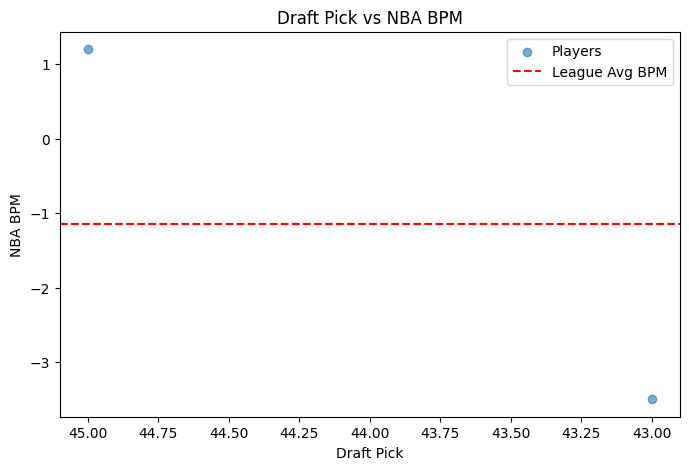

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(draft_nba_df['pk'], draft_nba_df['bpm_y'], alpha=0.6, label='Players')
plt.axhline(draft_nba_df['bpm_y'].mean(), color='red', linestyle='--', label='League Avg BPM')
plt.xlabel("Draft Pick")
plt.ylabel("NBA BPM")
plt.title("Draft Pick vs NBA BPM")
plt.gca().invert_xaxis()  # lower draft pick = better
plt.legend()
plt.show()

For this sample, we can see that the player drafted later (45th pick) had a significantly higher NBA BPM than the player drafted earlier (43rd pick). This suggests that for these two players, the draft order was not a good predictor of their performance as measured by BPM

## 4.2 College WS/48 vs NBA Prospects

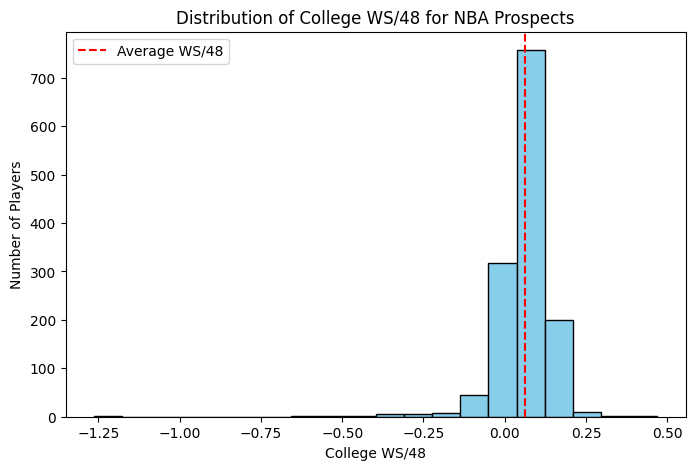

In [ ]:
# Convert ws/48 to numeric, coercing errors to NaN
draft_df['ws/48'] = pd.to_numeric(draft_df['ws/48'], errors='coerce')

plt.figure(figsize=(8,5))
plt.hist(draft_df['ws/48'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.axvline(draft_df['ws/48'].dropna().mean(), color='red', linestyle='--', label='Average WS/48')
plt.xlabel("College WS/48")
plt.ylabel("Number of Players")
plt.title("Distribution of College WS/48 for NBA Prospects")
plt.legend()
plt.show()


This histogram illustrates the distribution of College Win Shares per 48 minutes for a dataset of NBA prospects. This shows that the College Win Shares for NBA prospects is heavily concentrated around a positive, above-average value. This is expected, since NBA teams generally select players who have demonstrated a high level of efficiency and positive contribution. However, there are still a lot of players who are below 0, which are our underdogs which we will try to find.

## 4.3 Wingspan vs. Player Height

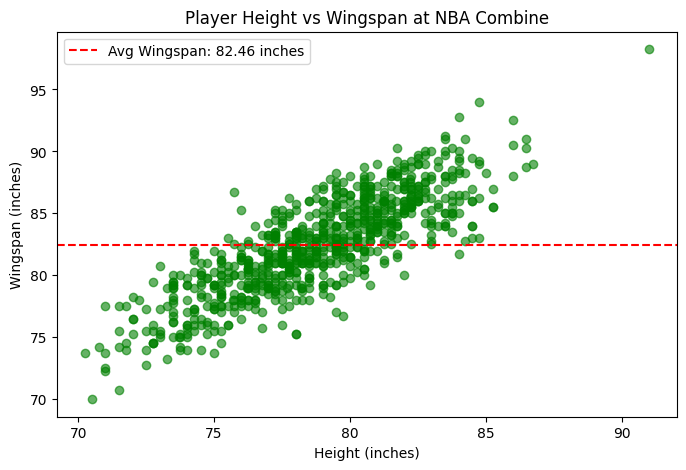

In [ ]:
mean_wingspan = combine_df['wingspan'].mean()

plt.figure(figsize=(8,5))
plt.scatter(combine_df['height_w_shoes'], combine_df['wingspan'], alpha=0.6, color='green')

plt.axhline(mean_wingspan,
            color='red',
            linestyle='--',
            label=f'Avg Wingspan: {mean_wingspan:.2f} inches')

plt.xlabel("Height (inches)")
plt.ylabel("Wingspan (inches)")
plt.title("Player Height vs Wingspan at NBA Combine")
plt.legend()
plt.show()

The plot visually confirms that height is an excellent predictor of wingspan among NBA prospects. Crucially for basketball, the data highlights that most prospects selected for the NBA Combine possess a wingspan that is disproportionately long compared to their height, suggesting the NBA prioritizes this physical advantage.

## 4.4 NBA vs. Draft EDA

Take players in nba_total_df and match to draft_df. compare player's NBA advanced stats to their draft number and league-wide average advanced stats. Identify specific players with above-average advanced metrics and see how their draft position compares

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(combine_df['wingspan'], ncaa_df['BPM'])
plt.xlabel("Wingspan (inches)")
plt.ylabel("BPM")
plt.title("Wingspan vs College BPM")
plt.show()


Explanation

Also compare how draft position correlates with NBA outcomes such as awards, longterm advanced stats (PER, BPM, WS). Identify common advanced metrics that successful players share

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(combine_df['wingspan'], ncaa_df['BPM'])
plt.xlabel("Wingspan (inches)")
plt.ylabel("BPM")
plt.title("Wingspan vs College BPM")
plt.show()


Explanation

## 4.5 NCAA vs. Draft EDA

Compare draft pick with college performance by merging draft_df and ncaa_df. Identify which college stats translate best into draft position

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(combine_df['max_vertical_leap'].dropna(), bins=20)
plt.xlabel("Max Vertical Leap (inches)")
plt.ylabel("Count")
plt.title("Distribution of Max Vertical Leap")
plt.show()


Explanation

## 4.6 College vs. Draft vs. NBA

Average stats by draft pick and compare these averages to average college stats by pick and average nba stats by pick.

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(ncaa_df['eFG'], combine_df['three_quarter_sprint'])
plt.xlabel("NCAA eFG%")
plt.ylabel("Three-Quarter Sprint (sec)")
plt.title("eFG% vs Sprint Time")
plt.show()


Explanation

## 4.7 Heatmap + Feature Correlation Matrix

We will apply a Heatmap + Feature Correlation Matrix to quickly identify strong corrleations in our data before heading into more advanced models.

##4.8 Principal Component Analysis

We will do PCA on all dataframes and capture any features that stand out. This works particularly well for our data because we have so many features and statistics. We hope that PCA can help reduce dimensionality and capture the most important patterns in the data, as well as remove redundancy on our data.

# Part 5: Feature Engineering & Preprocessing (All data sets in one)

# Part 6: Modeling

## 6.1 Logistic Regression Modeling

We wanted to predict whether a NBA prospect becomes an above-average NBA player. Using features from college statistics and draft information, we will train a logistic regression model because it provides a simple and interpretable way, before we move onto more advanced models.

In [ ]:
# -----------------------------
# Prepare features (draft + college)
# -----------------------------
df = draft_df.copy()

# Only use numeric features we know exist
df = df[['player','pk','bpm','ws/48']].dropna()  # college bpm and ws/48
df = df.rename(columns={'bpm':'college_bpm', 'ws/48':'college_ws48'})

# -----------------------------
# Prepare target from NBA advanced stats
# -----------------------------
nba_df = advanced_df.copy()
nba_df = nba_df[['player','bpm']].dropna()
nba_df = nba_df.rename(columns={'bpm':'nba_bpm'})

# Merge on player name only
df = df.merge(nba_df, on='player', how='inner')

# Define binary target: above-average NBA BPM
nba_avg_bpm = df['nba_bpm'].mean()
df['above_avg_nba'] = (df['nba_bpm'] > nba_avg_bpm).astype(int)

# -----------------------------
# Features and target
# -----------------------------
X = df[['college_bpm','college_ws48','pk']]
y = df['above_avg_nba']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# Train logistic regression
# -----------------------------
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# -----------------------------
# Inspect coefficients
# -----------------------------
coef_df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_[0]})
print(coef_df)


              precision    recall  f1-score   support

           0       0.80      0.78      0.79       541
           1       0.75      0.77      0.76       461

    accuracy                           0.78      1002
   macro avg       0.77      0.78      0.77      1002
weighted avg       0.78      0.78      0.78      1002

ROC-AUC: 0.852642932466189
        feature  coefficient
0   college_bpm     1.056001
1  college_ws48     0.859029
2            pk     0.005902


The model achieved an overall accuracy of 78%, correctly identifying most above- and below-average players, with a strong ROC-AUC of 0.85 indicating good ability to separate the two groups. Examining the feature coefficients, college performance metrics—BPM and WS/48—were the most influential predictors, with higher values strongly increasing the likelihood of NBA success. Draft pick had a much smaller effect, suggesting that while being selected earlier can help, a player’s college performance is the dominant factor in predicting above-average NBA performance.

## 6.2 Random Forest

Our next model will be a Random Forest model. This will be a step up from our Logistic Regression model because it captures RF captures non-linear relationships and captures complex relationships between statistics. This is impotant because we have many statistics and want feature importance to help identify stars in the NBA

## 6.4 XGBoost to Predict the 2026 NBA Draft Class

Our final model will be an XGBoost model, which is the gold standard model for tabular sports data. This is because it not only handles non-linearity, outliers, and weak signals, but it also reduces variance and optimizes our data with tree pruning and regularization, which will be valuable for later analysis. In the NBA, we know that some features matter more in certain ranges, and combinations of features (like wingspan + block rate) matter together.

# Part 7: Conclusion

First, we merge mo's career avg with ethan's career avg and get advanced metrics.

Then that with bennett's career averages.

Second, look at those players and compare to mo's draft dataframe and compare player's advanced stats and average those stats and look at players with above average stats and compare to their draft number.

Then, compare the same player's college numbers to the draft.

Draft to NBA and compare which types of players are getting any awards, top 3. and look at advanced metrics which players have in common

And merge combine data and draft data but before we compare draft nba and draft to college.

For draft dataset, we have ranking of draft and we can average stats by pick number. so we can have average stats by draft pick. with advanced metrics. and also for undrafted guys. and compare that to college stats and nba stats.

and now we are looking for certain stats that stand out between players who go from college to draft to nba and have certain metrics that line up together. more than one stat